# Appendix

March 28, 2025

In [1]:
from functools import partial
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import seaborn as sns

# Models

In [2]:
def get_N(num_layers, d_model, n_q_per_kv, n_kv, d_head, d_ff):
    """Calculates body parameters for a GQA-SwiGLU transformer.
    n_q_per_kv is the number of query heads per KV head and n_kv is the number of KV heads."""
    lns = 2 * d_model  # ln1, ln2
    mhsa_read = (n_q_per_kv + 2) * n_kv * d_model * d_head  # w_q, w_k, w_v
    mhsa_write = n_q_per_kv * n_kv * d_head * d_model  # w_o
    swiglu_read = 2 * d_model * d_ff  # w_gate, w_up
    swiglu_write = d_ff * d_model  # w_down
    return num_layers * (lns + mhsa_read + mhsa_write + swiglu_read + swiglu_write)

In [3]:
target = {"num_layers": 8, "d_model": 512, "n_q_per_kv": 1, "n_kv": 8, "d_head": 128, "d_ff": 4096}
vanilla_sd_draft = {"num_layers": 4, "d_model": 256, "n_q_per_kv": 1, "n_kv": 8, "d_head": 64, "d_ff": 2048}
spire_draft = {"num_layers": 2, "d_model": 512, "n_q_per_kv": 1, "n_kv": 8, "d_head": 128, "d_ff": 4096}

print(f"{'Target model (seqax 67M):':<25}{get_N(**target):>15,} body parameters")
print(f"{'Vanilla SD draft:':<25}{get_N(**vanilla_sd_draft):>15,} body parameters")
print(f"{'SPIRe draft:':<25}{get_N(**spire_draft):>15,} body parameters")

Target model (seqax 67M):     67,117,056 body parameters
Vanilla SD draft:              8,390,656 body parameters
SPIRe draft:                  16,779,264 body parameters


# Evaluation Metric

Recall that our evaluation metric is
$$
\begin{align*}
    \text{Throughput Multiplier} = \frac{\mathbb{E}[\text{\# Tokens Generated per Round of Speculation}]}{\frac{k \times t_\text{draft} + t_\text{verify}}{t_\text{target}}}
\end{align*}
$$
where we approximate the *iteration time multiplier* $\Delta t := \frac{k \times t_\text{draft} + t_\text{verify}}{t_\text{target}}$ by
$$
\begin{align*}
    \frac{k \times \max(C_\text{draft}, (N_\text{draft} + \text{KV}_\text{draft}) \times \text{HOI}) + \max((k + 1) \times C_\text{target}, (N_\text{target} + \text{KV}_\text{target}) \times \text{HOI})}{\max(C_\text{target}, (N_\text{target} + \text{KV}_\text{target}) \times \text{HOI})}.
\end{align*}
$$
Here, $C_\text{draft}$ is the number of FLOPs performed during a forward pass through the draft model, $N_\text{draft}$ is the size of the draft model's weights in bytes, $\text{KV}_\text{draft}$ is the size of the draft model's KV cache in bytes, and similarly for $C_\text{target}$, $N_\text{target}$, and $\text{KV}_\text{target}$.

## Calculating iteration time multipliers
- We parameterize the size of the sliding window as $\frac{L}{\texttt{window\_factor}}$ so that the size of the sliding window is some fixed fraction of the context length $L$.

    In particular, we use $\tau$'s (average generation lengths) corresponding to a medium context length of $L=512$ to calculate all throughput multipliers $\tau / \Delta t$ in Figures 1, 4, 5 and 6, by assuming that $\tau$ is the same when generating with shorter or longer contexts. 

    Since we focus on a context of 512 tokens, and we use a [StreamingLLM attention mask](https://arxiv.org/pdf/2309.17453#page=2) with a window size of 64 and a sink size of 1, we fix $\texttt{window\_factor} = 8$.

- All values are stored as a 1-byte data type.

In [4]:
def calculate_itm(B, L, target, k, HOI, f, N_target, N_draft, kv_draft, FLOPs_draft):
    kv_target = B * L * 2 * target["num_layers"] * target["n_kv"] * target["d_head"]  # Load KV cache
    FLOPs_target = 2 * N_target * B  # FLOPs to decode 1 token (https://arxiv.org/pdf/2001.08361#page=7)
    FLOPs_verify = FLOPs_target * (k + 1)  # FLOPs to verify k + 1 tokens (https://arxiv.org/pdf/2001.08361#page=7)
    speculate_cost = k * f(FLOPs_draft, (N_draft + kv_draft) * HOI)
    verify_cost = f(FLOPs_verify, (N_target + kv_target) * HOI)
    target_cost = f(FLOPs_target, (N_target + kv_target) * HOI)
    return (speculate_cost + verify_cost) / target_cost

In [5]:
def get_itm_vanilla(B, L, target, draft, k, HOI, f):
    N_target = get_N(**target)
    N_draft = get_N(**draft)
    kv_draft = B * L * 2 * draft["num_layers"] * draft["n_kv"] * draft["d_head"]  # Load KV cache
    FLOPs_draft = 2 * N_draft * B  # FLOPs to decode 1 token (https://arxiv.org/pdf/2001.08361#page=7)
    return calculate_itm(B, L, target, k, HOI, f, N_target, N_draft, kv_draft, FLOPs_draft)

In [6]:
def get_itm_magicdec(B, L, target, draft, k, HOI, f, sink_size=1, window_factor=8):
    """MagicDec ([Chen et al. (2024)](https://arxiv.org/abs/2408.11049v3))"""
    N_target = get_N(**target)
    Klen = sink_size + L // window_factor if window_factor else L  # StreamingLLM attention mask (https://arxiv.org/pdf/2309.17453#page=2)
    kv_draft = B * Klen * 2 * target["num_layers"] * target["n_kv"] * target["d_head"]  # Load KV cache
    FLOPs_draft = 2 * N_target * B  # FLOPs to decode 1 token (https://arxiv.org/pdf/2001.08361#page=7)
    return calculate_itm(B, L, target, k, HOI, f, N_target, N_target, kv_draft, FLOPs_draft)

In [7]:
def get_itm_spire(B, L, target, draft, k, HOI, f, sink_size=1, window_factor=8):
    """SPIRe (ours)"""
    N_target = get_N(**target)
    N_draft = get_N(**draft)
    N_draft_kv_params = 2 * draft["num_layers"] * draft["n_kv"] * draft["d_model"] * draft["d_head"]
    Klen = sink_size + L // window_factor if window_factor else L  # StreamingLLM attention mask (https://arxiv.org/pdf/2309.17453#page=2)
    kv_draft = B * Klen * 2 * draft["num_layers"] * draft["n_kv"] * draft["d_head"]  # Load KV cache
    FLOPs_draft = 2 * N_draft * B  # FLOPs to decode 1 token (https://arxiv.org/pdf/2001.08361#page=7)
    FLOPs_draft += 2 * N_draft_kv_params * B  # FLOPs to project 1 memory vector into a key and a value for the next iteration (https://arxiv.org/pdf/2001.08361#page=7)
    return calculate_itm(B, L, target, k, HOI, f, N_target, N_draft, kv_draft, FLOPs_draft)

# Figures

In [8]:
taus = {"vanilla_sd": 2.647, "magicdec": 3.891, "spire": 3.401}

## Figure 1

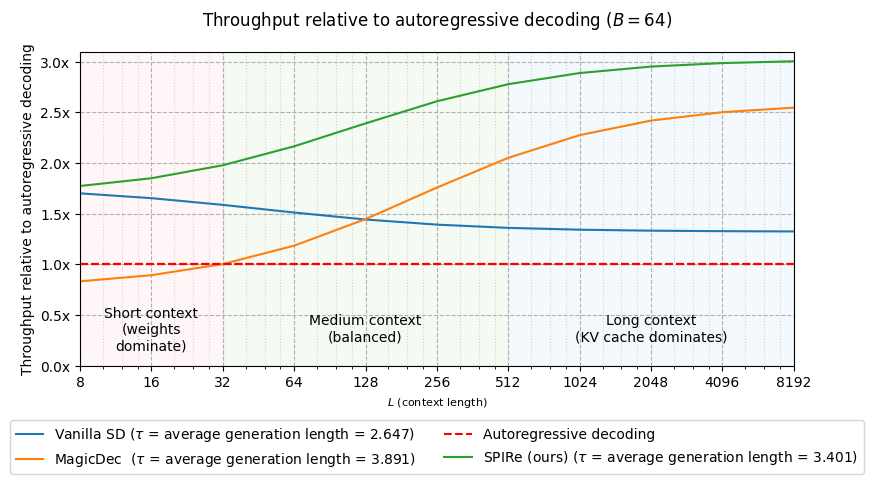

In [9]:
def plot_multipliers_slice(
        target, draft, get_itm_variant, label, ax, tau=None, L_values=2**np.arange(3, 14), define_tau=True,
        add_ad_label=False, add_regions=False, largest_short_context=64, largest_medium_context=1024,
        add_region_labels=False, region_label_heights=[0.55, 0.55, 0.55], y_min=0.0, y_max=3.1,
        alternate=False
    ):
    BATCH_SIZE = 64
    MAX_SPECULATION_DEPTH = 4
    HOI = 600

    if alternate:
        # See the end of this notebook for a description of an alternative way to calculate throughput multipliers
        assert tau is not None
        multipliers = np.array(
            [get_itm_variant(BATCH_SIZE, L, 64, target, draft, tau, MAX_SPECULATION_DEPTH, HOI=HOI, f=max)
             for L in L_values]
        )  # Throughput multipliers
    else:
        multipliers = np.array(
            [get_itm_variant(BATCH_SIZE, L, target, draft, MAX_SPECULATION_DEPTH, HOI=HOI, f=max)
             for L in L_values]
        )  # Iteration time multipliers
        if tau:
            # If tau is None, multipliers are iteration time multipliers
            multipliers = tau / multipliers  # Throughput multipliers

    ax.axhline(1.0, color='red', linestyle='--', label='Autoregressive decoding' if add_ad_label else None)
    ax.semilogx(L_values, multipliers,
                label=label + f" ($\\tau$ {'= average generation length' if define_tau else ''} = {tau})")

    ax.set_xscale('log', base=2)
    ax.set_xticks(L_values)
    ax.set_xticklabels([str(int(x)) for x in L_values], rotation=0, fontsize=10)
    minor_ticks = []
    for i in range(len(L_values)-1):
        start = L_values[i]
        minor_positions = np.array([start * 1.25, start * 1.5, start * 1.75])
        minor_ticks.extend(minor_positions)
    minor_ticks = np.array(minor_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_xticklabels([""] * len(minor_ticks), minor=True)
    ax.set_xlim(L_values.min(), L_values.max())
    ax.set_xlabel('$L$ (context length)', fontsize=8)

    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x:.1f}x'))
    ax.set_ylim(y_min, y_max)
    ax.set_ylabel('Throughput relative to autoregressive decoding', fontsize=10)

    ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)

    ax.grid(True, which='major', linestyle='--', alpha=1.0)
    ax.grid(True, which='minor', linestyle=':', alpha=0.5)

    if add_regions:
        region_boundaries = [L_values[0], largest_short_context, largest_medium_context, L_values[-1]]
        region_labels = ["Short context\n(weights\ndominate)", "Medium context\n(balanced)", "Long context\n(KV cache dominates)"]
        region_colors = ["#ffe6e6", "#dff0d8", "#d9edf7"]
        for i, h in zip(range(len(region_boundaries) - 1), region_label_heights):
            ax.axvspan(region_boundaries[i], region_boundaries[i+1], color=region_colors[i], alpha=0.3)
            if add_region_labels:
                mid_x = 2 ** ((np.log2(region_boundaries[i]) + np.log2(region_boundaries[i+1])) / 2)
                ax.text(mid_x, ax.get_ylim()[1] * h, region_labels[i], ha='center', fontsize=10, color='black')


fig, ax = plt.subplots(1, 1, figsize=(9, 5))
fig.suptitle("Throughput relative to autoregressive decoding ($B=64$)")
plot_multipliers_slice(target, vanilla_sd_draft, get_itm_vanilla, "Vanilla SD", ax, tau=taus["vanilla_sd"])
plot_multipliers_slice(target, None, get_itm_magicdec, "MagicDec ", ax, tau=taus["magicdec"])
plot_multipliers_slice(target, spire_draft, get_itm_spire, "SPIRe (ours)", ax, tau=taus["spire"],
                       add_ad_label=True, add_regions=True, largest_short_context=32, largest_medium_context=512,
                       add_region_labels=True, region_label_heights=[0.05, 0.08, 0.08])
plt.tight_layout()
plt.show()

## Figure 3

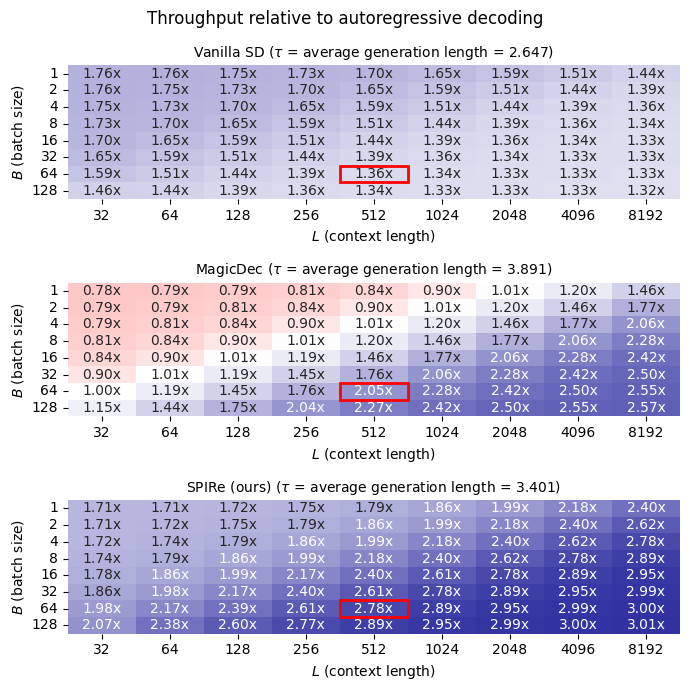

In [10]:
vmax = 3.5  # Chosen for greater contrast
colors = [(0.0, "red"), (1 / vmax, "white"), (1.0, "darkblue")]
colors_r = [(0.0, "darkblue"), (1 / vmax, "white"), (1.0, "red")]
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors_r)

def plot_multipliers(
        target, draft, get_itm_variant, title, ax, tau=None, define_tau=True,
        B_values=2**np.arange(0, 8), L_values=2**np.arange(5, 14), Lh=512, Bh=64,
        alternate=False
    ):
    MAX_SPECULATION_DEPTH = 4
    HOI = 600

    if alternate:
        # See the end of this notebook for a description of an alternative way to calculate throughput multipliers
        assert tau is not None
        multipliers = np.array(
            [[get_itm_variant(B, L, 64, target, draft, tau, MAX_SPECULATION_DEPTH, HOI, f=max)
              for L in L_values] for B in B_values]
        )  # Throughput multipliers
    else:
        multipliers = np.array(
            [[get_itm_variant(B, L, target, draft, MAX_SPECULATION_DEPTH, HOI, f=max)
              for L in L_values] for B in B_values]
        )  # Iteration time multipliers
        if tau:
            # If tau is None, multipliers are iteration time multipliers
            multipliers = tau / multipliers  # Throughput multipliers

    sns.heatmap(
        multipliers,
        xticklabels=L_values,
        yticklabels=B_values,
        cmap=cmap if tau else cmap_r,
        annot=[[f'{x:.2f}x' for x in row] for row in multipliers],
        fmt='',
        annot_kws={'size': 10},
        vmin=0.0,
        vmax=vmax,
        cbar=False,
        ax=ax
    )

    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_xlabel('$L$ (context length)', fontsize=10)

    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_ylabel('$B$ (batch size)', fontsize=10)

    tau_title = f" ($\\tau$ = {'average generation length = ' if define_tau else ''}{tau})" if tau else ""
    ax.set_title(f"{title}{tau_title}", fontsize=10)

    if Bh in B_values and Lh in L_values:
        ax.add_patch(Rectangle(
            (np.where(L_values == Lh)[0][0], np.where(B_values == Bh)[0][0]),
            1, 1, fill=False, edgecolor='red', linewidth=2
        ))


fig, axs = plt.subplots(3, 1, figsize=(7, 7))
fig.suptitle("Throughput relative to autoregressive decoding")
plot_multipliers(target, vanilla_sd_draft, get_itm_vanilla, "Vanilla SD", axs[0], tau=taus["vanilla_sd"])
plot_multipliers(target, None, get_itm_magicdec, "MagicDec", axs[1], tau=taus["magicdec"])
plot_multipliers(target, spire_draft, get_itm_spire, "SPIRe (ours)", axs[2], tau=taus["spire"])
plt.tight_layout()
plt.show()

## Figure 4

We obtain a hardware operational intensity (HOI) of approximately 600 for an NVIDIA H100 GPU from https://resources.nvidia.com/en-us-tensor-core/nvidia-tensor-core-gpu-datasheet by first dividing the FP8 Tensor Core performance for the H100 SXM by 2 to get the FP8 Tensor Core performance without sparsity, and then dividing that by the GPU Memory Bandwidth for the H100 SXM.

In [11]:
seqax_67m = {"num_layers": 8, "d_model": 512, "n_q_per_kv": 1, "n_kv": 8, "d_head": 128, "d_ff": 4096}
llama3_70b = {"num_layers": 80, "d_model": 8192, "n_q_per_kv": 8, "n_kv": 8, "d_head": 128, "d_ff": 28672}  # https://arxiv.org/pdf/2407.21783#page=7

print(f"{'seqax 67M:':<15}{get_N(**seqax_67m):>15,} body parameters")
print(f"{'Llama 3 70B:':<15}{get_N(**llama3_70b):>15,} body parameters")

seqax 67M:          67,117,056 body parameters
Llama 3 70B:    68,452,352,000 body parameters


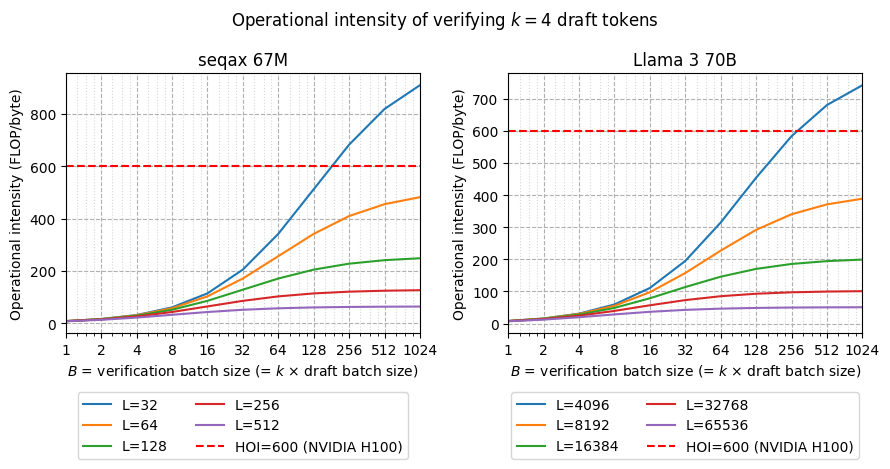

In [12]:
def plot_verification_operational_intensity(
        model, title, ax, B_values=2**np.arange(0, 11), L_values=2**np.arange(5, 10)
    ):
    MAX_SPECULATION_DEPTH = 4
    HOI = 600

    N = get_N(**model)
    x = 2 * model["num_layers"] * model["n_kv"] * model["d_head"]
    for L in L_values:
        ax.plot(B_values, (2 * N * (B_values * MAX_SPECULATION_DEPTH)) / (N + B_values * L * x), label=f'L={L}')

    ax.axhline(HOI, color='red', linestyle='--', label=f'HOI={HOI} (NVIDIA H100)')

    ax.set_xscale('log', base=2)
    ax.set_xticks(B_values)
    ax.set_xticklabels([str(int(x)) for x in B_values], rotation=0, fontsize=10)
    minor_ticks = []
    for i in range(len(B_values)-1):
        start = B_values[i]
        minor_positions = np.array([start * 1.25, start * 1.5, start * 1.75])
        minor_ticks.extend(minor_positions)
    minor_ticks = np.array(minor_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_xticklabels([""] * len(minor_ticks), minor=True)
    ax.set_xlim(B_values.min(), B_values.max())
    ax.set_xlabel('$B$ = verification batch size (= $k$ $\\times$ draft batch size)', fontsize=10)

    ax.set_ylabel('Operational intensity (FLOP/byte)', fontsize=10)

    ax.set_title(title)

    ax.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=2)

    ax.grid(True, which='major', linestyle='--', alpha=1.0)
    ax.grid(True, which='minor', linestyle=':', alpha=0.5)


fig, axs = plt.subplots(1, 2, figsize=(9, 5))
axs = axs.flatten()
plot_verification_operational_intensity(seqax_67m, "seqax 67M", axs[0])
plot_verification_operational_intensity(llama3_70b, "Llama 3 70B", axs[1], L_values=2**np.arange(12, 17))
plt.suptitle("Operational intensity of verifying $k=4$ draft tokens")
plt.tight_layout()
plt.show()

## Figure 5

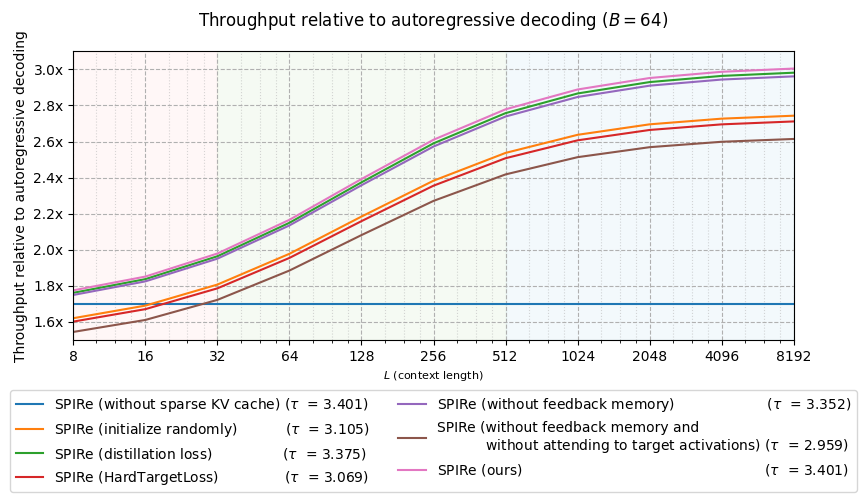

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5.25))
fig.suptitle("Throughput relative to autoregressive decoding ($B=64$)")
plot_multipliers_slice(target, spire_draft, partial(get_itm_spire, window_factor=None), "SPIRe (without sparse KV cache)", ax, tau=taus["spire"], define_tau=False)
plot_multipliers_slice(target, spire_draft, get_itm_spire, "SPIRe (initialize randomly)          ", ax, tau=3.105, define_tau=False)
plot_multipliers_slice(target, spire_draft, get_itm_spire, "SPIRe (distillation loss)               ", ax, tau=3.375, define_tau=False)
plot_multipliers_slice(target, spire_draft, get_itm_spire, "SPIRe (HardTargetLoss)              ", ax, tau=3.069, define_tau=False)
plot_multipliers_slice(target, spire_draft, get_itm_spire, "SPIRe (without feedback memory)                    ", ax, tau=3.352, define_tau=False)
plot_multipliers_slice(target, spire_draft, get_itm_spire, "SPIRe (without feedback memory and\n           without attending to target activations)", ax, tau=2.959, define_tau=False)
plot_multipliers_slice(target, spire_draft, get_itm_spire, "SPIRe (ours)                                                      ", ax, tau=taus["spire"], define_tau=False,
                       add_ad_label=False, add_regions=True, largest_short_context=32, largest_medium_context=512,
                       add_region_labels=False, region_label_heights=[0.88, 0.90, 0.68], y_min=1.5, y_max=3.1)
plt.tight_layout()
plt.show()

The throughput multiplier for SPIRe (without sparse KV cache) is constant with respect to the context length $L$ above since here the memory cost of generating a token is higher than the compute cost, and since $k=4$ and $N_\text{target} = 4 \times N_\text{draft}$, $L$ cancels out in our expression for the iteration time multiplier $\Delta t$. 

As shown below, it's only with larger batch sizes and sufficiently short contexts that the compute cost of generating a token is higher than the memory cost, and the throughput multiplier varies with respect to the context length.

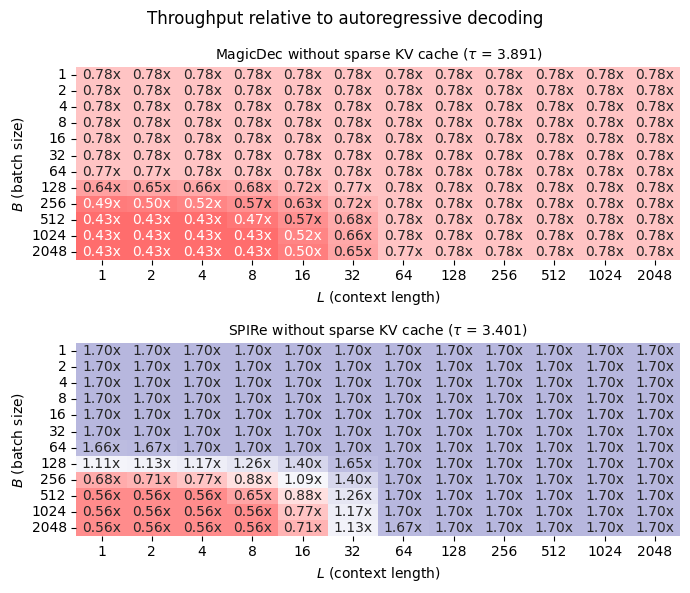

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(7, 6))
fig.suptitle("Throughput relative to autoregressive decoding")
B_values = 2 ** np.arange(0, 12)
L_values = 2 ** np.arange(0, 12)
plot_multipliers(target, None, partial(get_itm_magicdec, window_factor=None), "MagicDec without sparse KV cache", axs[0],
                 tau=taus["magicdec"], define_tau=False, B_values=B_values, L_values=L_values, Lh=None, Bh=None)
plot_multipliers(target, spire_draft, partial(get_itm_spire, window_factor=None), "SPIRe without sparse KV cache", axs[1],
                 tau=taus["spire"], define_tau=False, B_values=B_values, L_values=L_values, Lh=None, Bh=None)
plt.tight_layout()
plt.show()

## Figure 6

In [15]:
h_target = {"num_layers": 80, "d_model": 8192, "n_q_per_kv": 8, "n_kv": 8, "d_head": 128, "d_ff": 28672}  # Llama 3 70B
h_vanilla_sd_draft = {"num_layers": 32, "d_model": 4096, "n_q_per_kv": 4, "n_kv": 8, "d_head": 128, "d_ff": 14336}  # Llama 3 8B
h_spire_draft = {"num_layers": 20, "d_model": 8192, "n_q_per_kv": 8, "n_kv": 8, "d_head": 128, "d_ff": 28672}

print(f"{'Target model (Llama 3 70B):':<30}{get_N(**h_target):>15,} body parameters")
print(f"{'Scaled-up vanilla SD draft:':<30}{get_N(**h_vanilla_sd_draft):>15,} body parameters")
print(f"{'Scaled-up SPIRe draft:':<30}{get_N(**h_spire_draft):>15,} body parameters")

Target model (Llama 3 70B):    68,452,352,000 body parameters
Scaled-up vanilla SD draft:     6,979,584,000 body parameters
Scaled-up SPIRe draft:         17,113,088,000 body parameters


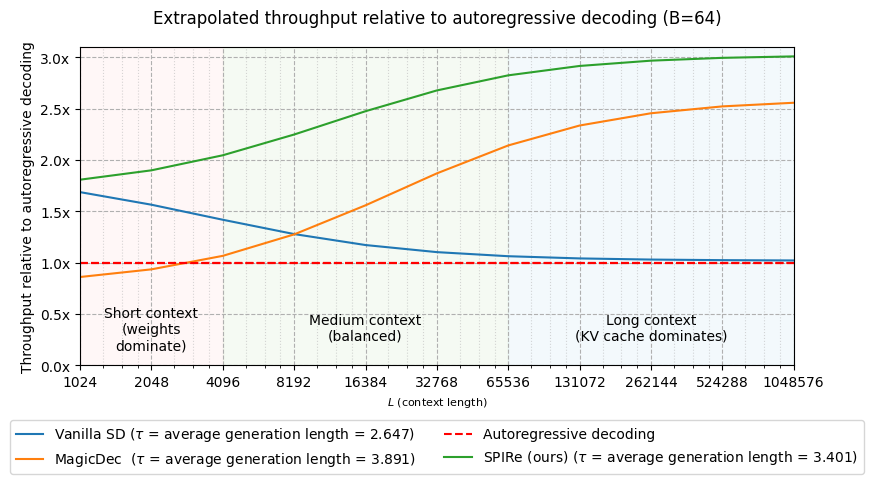

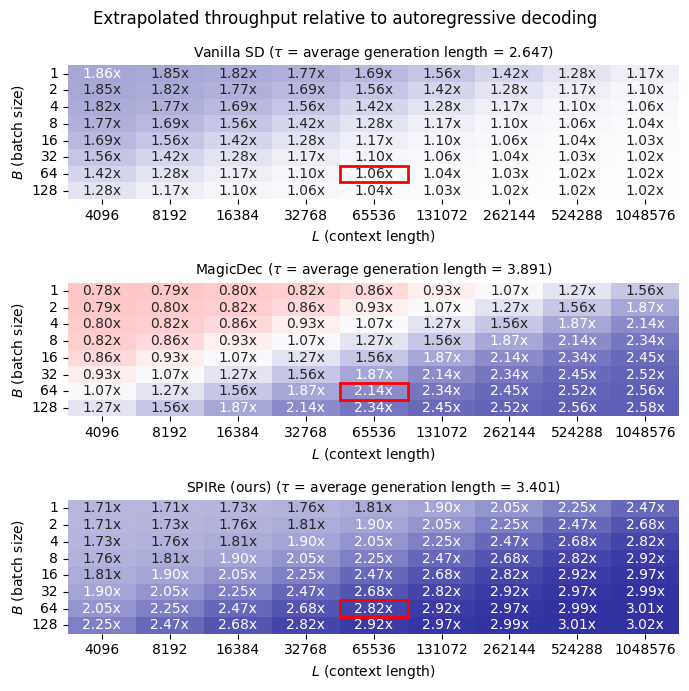

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
fig.suptitle("Extrapolated throughput relative to autoregressive decoding (B=64)")
L_values = 2 ** np.arange(10, 21)
plot_multipliers_slice(h_target, h_vanilla_sd_draft, get_itm_vanilla, "Vanilla SD", ax, tau=taus["vanilla_sd"], L_values=L_values)
plot_multipliers_slice(h_target, None, get_itm_magicdec, "MagicDec ", ax, tau=taus["magicdec"], L_values=L_values)
plot_multipliers_slice(h_target, h_spire_draft, get_itm_spire, "SPIRe (ours)", ax, tau=taus["spire"], L_values=L_values,
                       add_ad_label=True, add_regions=True, largest_short_context=4096, largest_medium_context=65536,
                       add_region_labels=True, region_label_heights=[0.05, 0.08, 0.08])
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(3, 1, figsize=(7, 7))
fig.suptitle("Extrapolated throughput relative to autoregressive decoding")
L_values = 2 ** np.arange(12, 21)
plot_multipliers(h_target, h_vanilla_sd_draft, get_itm_vanilla, "Vanilla SD", axs[0],tau=taus["vanilla_sd"], L_values=L_values, Lh=65536)
plot_multipliers(h_target, None, get_itm_magicdec, "MagicDec", axs[1], tau=taus["magicdec"], L_values=L_values, Lh=65536)
plot_multipliers(h_target, h_spire_draft, get_itm_spire, "SPIRe (ours)", axs[2], tau=taus["spire"], L_values=L_values, Lh=65536)
plt.tight_layout()
plt.show()

## Alternative Figure 1 and Figure 3

Note that our approximation of the throughput multiplier,
$$
\begin{align*}
    \frac{\mathbb{E}[\text{\# Tokens Generated per Round of Speculation}]}{\frac{k \times \max(C_\text{draft}, (N_\text{draft} + \text{KV}_\text{draft}) \times \text{HOI}) + \max((k + 1) \times C_\text{target}, (N_\text{target} + \text{KV}_\text{target}) \times \text{HOI})}{\max(C_\text{target}, (N_\text{target} + \text{KV}_\text{target}) \times \text{HOI})}},
\end{align*}
$$
ignores $G$, the total number of tokens generated, despite the dependence of $\text{KV}_{\text{draft}}$ and $\text{KV}_{\text{target}}$ on both $G$ and the context length $L$.

What if we don't ignore $G$ when calculating throughput multipliers? Explicitly denoting the dependence of $\text{KV}_{\text{draft}}(l)$ and $\text{KV}_{\text{target}}(l)$ on the current context length $l$, where $L \leq l \leq L + G$, we define
$$
\begin{align*}
    t_\text{speculate}^* &= \sum_{i=1}^{\lfloor G / \tau \rfloor} \sum_{j=1}^k \max(C_\text{draft}, (N_\text{draft} + \text{KV}_\text{draft}(L + i \tau + j)) \times \text{HOI}), \\
    t_\text{verify}^* &= \sum_{i=1}^{\lfloor G / \tau \rfloor} \max((k + 1) \times C_\text{target}, (N_\text{target} + \text{KV}_\text{target}(L + i \tau)) \times \text{HOI}), \text{ and} \\
    t_\text{ad}^* &= \sum_{i=1}^{G} \max(C_\text{target}, (N_\text{target} + \text{KV}_\text{target}(L + i)) \times \text{HOI}).
\end{align*}
$$
The quantity $t_\text{speculate}^*$ ($t_\text{verify}^*$) is supposed to approximate the total time spent drafting (verifying) tokens when generating $G$ tokens given a context of length $L$ with speculative decoding, so that $t_\text{speculate}^* + t_\text{verify}^*$ approximates the latency of generating $G$ tokens given a context of length $L$ with speculative decoding. The quantity $t_\text{ad}^*$ is supposed to approximate the latency of generating $G$ tokens given a context of length $L$ with autoregressive decoding. Thus, an alternative approximation of the throughput multiplier is given by
$$
\begin{align*}
    \frac{t_\text{ad}^*}{t_\text{speculate}^* + t_\text{verify}^*}.
\end{align*}
$$
Using this alternative approximation, we obtain variants of Figure 1 and Figure 3 which are essentially identical to the figures above which use our original approximation.

In [17]:
def get_t_verify(B, L, G, target, draft, tau, k, HOI, f):
    N_target = get_N(**target)
    kv_verify, FLOPs_verify, t_verify = 0, 0, 0
    g = 0
    while g < G:
        kv_verify = B * (L + g) * 2 * target["num_layers"] * target["n_kv"] * target["d_head"]  # Load KV cache
        FLOPs_verify = 2 * N_target * B * (k + 1)  # FLOPs to verify k + 1 tokens in parallel (https://arxiv.org/pdf/2001.08361#page=7)
        t_verify += f(FLOPs_verify, (N_target + kv_verify) * HOI)
        g += tau
    return t_verify


def get_t_ad(B, L, G, target, draft, tau, k, HOI, f):
    N_target = get_N(**target)
    kv_target, FLOPs_target, t_target = 0, 0, 0
    for g in range(G):
        kv_target = B * (L + g) * 2 * target["num_layers"] * target["n_kv"] * target["d_head"]  # Load KV cache
        FLOPs_target = 2 * N_target * B  # FLOPs to decode 1 token (https://arxiv.org/pdf/2001.08361#page=7)
        t_target += f(FLOPs_target, (N_target + kv_target) * HOI)
    return t_target

In [18]:
def get_tm_vanilla_alt(B, L, G, target, draft, tau, k, HOI, f):
    N_draft = get_N(**draft)
    kv_draft, FLOPs_draft, t_speculate = 0, 0, 0
    g = 0
    while g < G:
        for kappa in range(k):
            kv_draft = B * (L + g + kappa) * 2 * draft["num_layers"] * draft["n_kv"] * draft["d_head"]  # Load KV cache
            FLOPs_draft = 2 * N_draft * B  # FLOPs to decode 1 token (https://arxiv.org/pdf/2001.08361#page=7)
            t_speculate += f(FLOPs_draft, (N_draft + kv_draft) * HOI)
        g += tau
    t_verify = get_t_verify(B, L, G, target, draft, tau, k, HOI, f)
    t_ad = get_t_ad(B, L, G, target, draft, tau, k, HOI, f)
    return t_ad / (t_speculate + t_verify)

In [19]:
def get_tm_magicdec_alt(B, L, G, target, draft, tau, k, HOI, f, sink_size=1, window_factor=8):
    """MagicDec ([Chen et al. (2024)](https://arxiv.org/abs/2408.11049v3))"""
    N_draft = get_N(**draft)
    max_window_size = sink_size + L // window_factor if window_factor else L  # StreamingLLM attention mask (https://arxiv.org/pdf/2309.17453#page=2)
    kv_draft, FLOPs_draft, t_speculate = 0, 0, 0
    g = 0
    while g < G:
        for kappa in range(k):
            kv_draft = B * min(L + g + kappa, max_window_size) * 2 * draft["num_layers"] * draft["n_kv"] * draft["d_head"]  # Load KV cache
            FLOPs_draft = 2 * N_draft * B  # FLOPs to decode 1 token (https://arxiv.org/pdf/2001.08361#page=7)
            t_speculate += f(FLOPs_draft, (N_draft + kv_draft) * HOI)
        g += tau
    t_verify = get_t_verify(B, L, G, target, draft, tau, k, HOI, f)
    t_ad = get_t_ad(B, L, G, target, draft, tau, k, HOI, f)
    return t_ad / (t_speculate + t_verify)

In [20]:
def get_tm_spire_alt(B, L, G, target, draft, tau, k, HOI, f, sink_size=1, window_factor=8, recompute=False):
    """SPIRe (ours)"""
    N_draft = get_N(**draft)
    N_draft_kv_params = 2 * draft["num_layers"] * draft["n_kv"] * draft["d_model"] * draft["d_head"]
    max_window_size = sink_size + L // window_factor if window_factor else L  # StreamingLLM attention mask (https://arxiv.org/pdf/2309.17453#page=2)
    kv_draft, FLOPs_draft, t_speculate = 0, 0, 0
    g = 0
    while g < G:
        for kappa in range(k):
            kv_draft = B * min(L + g + kappa, max_window_size) * 2 * draft["num_layers"] * draft["n_kv"] * draft["d_head"]  # Load KV cache
            FLOPs_draft = 2 * N_draft * B  # FLOPs to decode 1 token (https://arxiv.org/pdf/2001.08361#page=7)
            FLOPs_draft += 2 * N_draft_kv_params * B  # FLOPs to project 1 memory vector into a key and a value for the next iteration (https://arxiv.org/pdf/2001.08361#page=7)
            t_speculate += f(FLOPs_draft, (N_draft + kv_draft) * HOI)
        g += tau
    t_verify = get_t_verify(B, L, G, target, draft, tau, k, HOI, f)
    t_ad = get_t_ad(B, L, G, target, draft, tau, k, HOI, f)
    return t_ad / (t_speculate + t_verify)

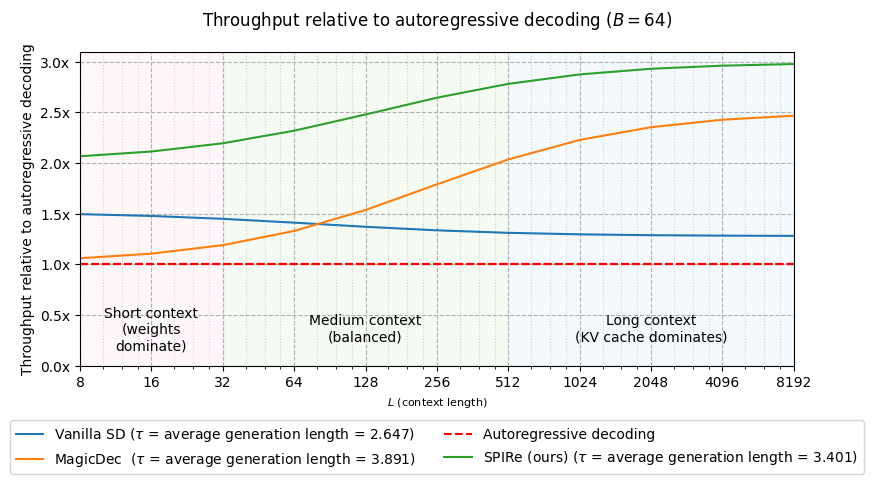

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
fig.suptitle("Throughput relative to autoregressive decoding ($B=64$)")
plot_multipliers_slice(target, vanilla_sd_draft, get_tm_vanilla_alt, "Vanilla SD", ax, tau=taus["vanilla_sd"], alternate=True)
plot_multipliers_slice(target, target, get_tm_magicdec_alt, "MagicDec ", ax, tau=taus["magicdec"], alternate=True)
plot_multipliers_slice(target, spire_draft, get_tm_spire_alt, "SPIRe (ours)", ax, tau=taus["spire"], alternate=True,
                       add_ad_label=True, add_regions=True, largest_short_context=32, largest_medium_context=512,
                        add_region_labels=True, region_label_heights=[0.05, 0.08, 0.08])
plt.tight_layout()
plt.show()

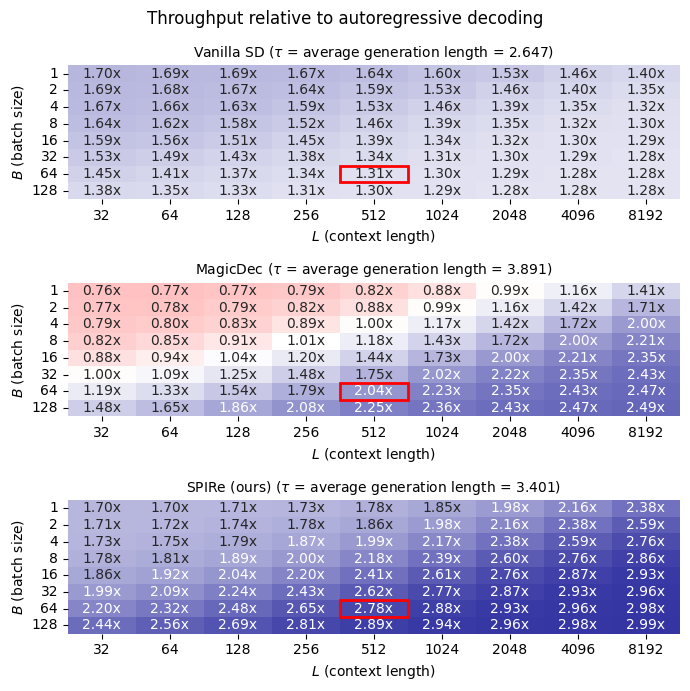

In [22]:
fig, axs = plt.subplots(3, 1, figsize=(7, 7))
fig.suptitle("Throughput relative to autoregressive decoding")
plot_multipliers(target, vanilla_sd_draft, get_tm_vanilla_alt, "Vanilla SD", axs[0], tau=taus["vanilla_sd"], alternate=True)
plot_multipliers(target, target, get_tm_magicdec_alt, "MagicDec", axs[1], tau=taus["magicdec"], alternate=True)
plot_multipliers(target, spire_draft, get_tm_spire_alt, "SPIRe (ours)", axs[2], tau=taus["spire"], alternate=True)
plt.tight_layout()
plt.show()